In [1]:
import os
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from process_log import Tags, Log, Epochs, generate_fitness_wc_dataframe
from tqdm.notebook import tqdm
from plot_helper import create_barplot, create_speedup_plot
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [2]:
df_gaul = pd.read_csv("benchmark_scaling_gaul_Dec_15_005105.gz")
df_gaul["mode"] = "gaul"
df_gaul

,fitness,wall clock time,epoch,rank,rep,n,mode
0,1671569,28.667,0,0,0,16,gaul
1,1668533,32.689,1,0,0,16,gaul
2,1668022,36.946,2,0,0,16,gaul
3,1667768,41.020,3,0,0,16,gaul
4,1652669,44.734,4,0,0,16,gaul
...,...,...,...,...,...,...,...
2248137,246716,300404.223,65017,0,4,2,gaul
2248138,246716,300408.771,65018,0,4,2,gaul
2248139,246716,300413.741,65019,0,4,2,gaul
2248140,246716,300418.283,65020,0,4,2,gaul


In [3]:
df_pga = pd.read_csv("benchmark_scaling_pgapack_Dec_15_020936.gz")
df_pga["mode"] = "pga"
df_pga

,fitness,wall clock time,epoch,rank,rep,n,mode
0,1681844,122.300,0,0,0,4,pga
1,1674758,124.465,1,0,0,4,pga
2,1652999,126.845,2,0,0,4,pga
3,1652999,129.185,3,0,0,4,pga
4,1652999,131.240,4,0,0,4,pga
...,...,...,...,...,...,...,...
3954633,183019,302613.050,174073,0,4,12,pga
3954634,183019,302614.792,174074,0,4,12,pga
3954635,183019,302616.542,174075,0,4,12,pga
3954636,183019,302618.282,174076,0,4,12,pga


In [4]:
df = df_gaul.copy()
df = df.append(df_pga, ignore_index=True)
df

,fitness,wall clock time,epoch,rank,rep,n,mode
0,1671569,28.667,0,0,0,16,gaul
1,1668533,32.689,1,0,0,16,gaul
2,1668022,36.946,2,0,0,16,gaul
3,1667768,41.020,3,0,0,16,gaul
4,1652669,44.734,4,0,0,16,gaul
...,...,...,...,...,...,...,...
6202775,183019,302613.050,174073,0,4,12,pga
6202776,183019,302614.792,174074,0,4,12,pga
6202777,183019,302616.542,174075,0,4,12,pga
6202778,183019,302618.282,174076,0,4,12,pga


In [5]:
max_wct = df.groupby(["rep", "n", "mode"]).agg({"wall clock time": "max"})["wall clock time"].min()
min_wct = df.groupby(["rep", "n", "mode"]).agg({"wall clock time": "min"})["wall clock time"].max()
thresholds = np.round(np.linspace(min_wct, max_wct, num=100), 0).astype(int)
thresholds

array([   193,   2933,   5672,   8412,  11151,  13890,  16630,  19369,
        22109,  24848,  27587,  30327,  33066,  35806,  38545,  41284,
        44024,  46763,  49503,  52242,  54981,  57721,  60460,  63200,
        65939,  68678,  71418,  74157,  76897,  79636,  82375,  85115,
        87854,  90594,  93333,  96072,  98812, 101551, 104291, 107030,
       109769, 112509, 115248, 117988, 120727, 123466, 126206, 128945,
       131685, 134424, 137163, 139903, 142642, 145382, 148121, 150860,
       153600, 156339, 159079, 161818, 164557, 167297, 170036, 172776,
       175515, 178254, 180994, 183733, 186473, 189212, 191951, 194691,
       197430, 200170, 202909, 205648, 208388, 211127, 213867, 216606,
       219345, 222085, 224824, 227564, 230303, 233043, 235782, 238521,
       241261, 244000, 246740, 249479, 252218, 254958, 257697, 260437,
       263176, 265915, 268655, 271394])

In [6]:
line_df = None
for threshold in tqdm(thresholds):
    tmp_df = df[df["wall clock time"] >= threshold].groupby(["rep", "n", "mode"]).agg({"fitness": "max"})
    tmp_df["wall clock time"] = threshold
    tmp_df = tmp_df.reset_index()

    if line_df is None:
        line_df = tmp_df
    else:
        line_df = line_df.append(tmp_df, ignore_index=True)
line_df

,rep,n,mode,fitness,wall clock time
0,0,2,gaul,1576727,193
1,0,2,pga,1585268,193
2,0,4,gaul,1549179,193
3,0,4,pga,1592440,193
4,0,8,gaul,1526499,193
...,...,...,...,...,...
4995,4,8,pga,183800,271394
4996,4,12,gaul,241808,271394
4997,4,12,pga,186013,271394
4998,4,16,gaul,252461,271394


In [7]:
threshold = 300000
to_keep = ["rep", "mode", "n", "epoch"]
df_n = df.groupby(to_keep, as_index=False).agg({"fitness": "min", "wall clock time": "max"}).drop(columns=["epoch"])
to_keep = ["rep", "mode", "n"]
df_reached = df_n[df_n.fitness <= threshold].groupby(to_keep).agg({"wall clock time": "min"})
df_reached

wall clock time
rep mode n                  
0   gaul 2         97796.316
         4         78394.542
         8         72791.227
         12        82149.236
         16       131849.738
    pga  2         59135.732
         4         61704.371
         8         63599.212
         12        70080.197
         16        62452.699
1   gaul 2        125601.426
         4         81129.310
         8         79792.704
         12       100559.229
         16       136957.104
    pga  2         60617.554
         4         62236.593
         8         63868.640
         12        66681.661
         16        63254.866
2   gaul 2        107524.400
         4         79589.104
         8         83597.457
         12        80363.294
         16       163166.430
    pga  2        114083.923
         4         63883.500
         8         65557.118
         12        63257.473
         16        63649.636
3   gaul 2        106033.792
         4         95006.919
         8         73667.356
         12        98086.532
         16       133828.903
    pga  2         72787.261
         4         62818.817
         8         63888.306
         12        58764.383
         16        61152.127
4   gaul 2        106431.219
         4         74453.829
         8         81646.662
         12       104145.251
         16       127954.029
    pga  2         61458.626
         4         56984.558
         8         60351.875
         12        50605.496
         16        60951.812

In [8]:
tmp = df_reached.reset_index()
baseline_gaul = tmp[tmp["n"] == 2][tmp["mode"] == "gaul"]["wall clock time"].mean()
baseline_pga = tmp[tmp["n"] == 2][tmp["mode"] == "pga"]["wall clock time"].mean()
print(baseline_gaul)
print(baseline_pga)

C:\Users\valen\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\valen\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


108677.4306
73616.6192


In [9]:
tmp = df_reached.reset_index()
tmp = tmp[tmp["mode"] == "gaul"]
tmp["wall clock time"] = tmp["wall clock time"].div(baseline_gaul)
tmp["wall clock time"] = 1 / tmp["wall clock time"]
df_speedup = tmp.copy()
tmp = df_reached.reset_index()
tmp = tmp[tmp["mode"] == "pga"]
tmp["wall clock time"] = tmp["wall clock time"].div(baseline_pga)
tmp["wall clock time"] = 1 / tmp["wall clock time"]
df_speedup = df_speedup.append(tmp, ignore_index=True)
df_speedup

,rep,mode,n,wall clock time
0,0,gaul,2,1.111263
1,0,gaul,4,1.386288
2,0,gaul,8,1.493002
3,0,gaul,12,1.322927
4,0,gaul,16,0.824252
5,1,gaul,2,0.865256
6,1,gaul,4,1.339558
7,1,gaul,8,1.361997
8,1,gaul,12,1.080731
9,1,gaul,16,0.793514


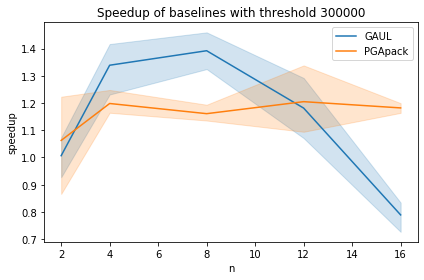

In [10]:
fig, ax = plt.subplots()
df_speedup = df_speedup.replace("gaul", "GAUL")
df_speedup = df_speedup.replace("pga", "PGApack")
legend = ["GAUL", "PGApack"]
sns.lineplot(ax=ax, x="n", y="wall clock time", hue="mode", data=df_speedup, legend="full")
ax.set(xlabel='n', ylabel='speedup')
ax.set_title(f"Speedup of baselines with threshold {threshold}")
plt.legend(legend)
fig.savefig(f"speedup_baselines_d1291_{threshold}.png", dpi=300)

In [11]:
df = df_gaul.copy()
df = df.append(df_pga, ignore_index=True)
df["n"] = df["n"].replace(2, 1)
df

,fitness,wall clock time,epoch,rank,rep,n,mode
0,1671569,28.667,0,0,0,16,gaul
1,1668533,32.689,1,0,0,16,gaul
2,1668022,36.946,2,0,0,16,gaul
3,1667768,41.020,3,0,0,16,gaul
4,1652669,44.734,4,0,0,16,gaul
...,...,...,...,...,...,...,...
6202775,183019,302613.050,174073,0,4,12,pga
6202776,183019,302614.792,174074,0,4,12,pga
6202777,183019,302616.542,174075,0,4,12,pga
6202778,183019,302618.282,174076,0,4,12,pga


In [12]:
df.n.unique()

array([16,  4,  8, 12,  1], dtype=int64)

In [13]:
df_scale = pd.read_csv("scaling_test_d1291_scaled_Dec_13_143716.gz")
df_combined = df.copy()
df_combined = df_combined.append(df_scale, ignore_index=True)
df_combined = df_combined[df_combined["n"] <= 16]
df_combined

C:\Users\valen\Miniconda3\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,elite_size,epoch,epochs,fitness,log_freq,migration_amount,mode,n,population,rank,rep,wall clock time
0,NaN,0,NaN,1671569,NaN,NaN,gaul,16,NaN,0,0,28.667
1,NaN,1,NaN,1668533,NaN,NaN,gaul,16,NaN,0,0,32.689
2,NaN,2,NaN,1668022,NaN,NaN,gaul,16,NaN,0,0,36.946
3,NaN,3,NaN,1667768,NaN,NaN,gaul,16,NaN,0,0,41.020
4,NaN,4,NaN,1652669,NaN,NaN,gaul,16,NaN,0,0,44.734
...,...,...,...,...,...,...,...,...,...,...,...,...
6912775,32.0,995,710000.0,144926,710.0,8.0,island,4,64.0,3,4,152522.214
6912776,32.0,996,710000.0,144926,710.0,8.0,island,4,64.0,3,4,152665.900
6912777,32.0,997,710000.0,144868,710.0,8.0,island,4,64.0,3,4,152809.569
6912778,32.0,998,710000.0,144867,710.0,8.0,island,4,64.0,3,4,152967.833


In [14]:
threshold = 300000
to_keep = ["rep", "mode", "n", "epoch"]
df_n = df_combined.groupby(to_keep, as_index=False).agg({"fitness": "min", "wall clock time": "max"}).drop(columns=["epoch"])
to_keep = ["rep", "mode", "n"]
df_reached = df_n[df_n.fitness <= threshold].groupby(to_keep).agg({"wall clock time": "min"})

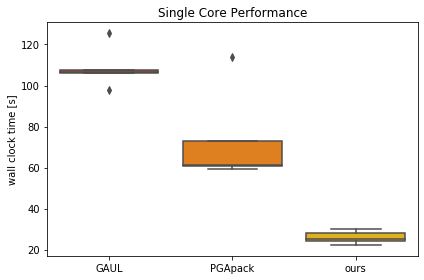

In [15]:
df_sc = df_reached.reset_index()
df_sc = df_sc[df_sc["n"] == 1]
df_sc = df_sc[df_sc["mode"] != "island"]
df_sc = df_sc.replace("naive", "ours")
df_sc = df_sc.replace("gaul", "GAUL")
df_sc = df_sc.replace("pga", "PGApack")
df_sc["wall clock time"] = df_sc["wall clock time"] / 1000
fig, ax = plt.subplots()
sns.boxplot(ax=ax, x="mode", y="wall clock time", order=["GAUL", "PGApack", "ours"], data=df_sc, palette="autumn")
ax.set_title("Single Core Performance")
ax.get_xaxis().set_label_text('')
ax.get_yaxis().set_label_text("wall clock time [s]")
fig.savefig("single_core_performance.png", dpi=300)

In [16]:
tmp = df_reached.reset_index()
baseline_gaul = tmp[tmp["n"] == 1][tmp["mode"] == "gaul"]["wall clock time"].mean()
baseline_pga = tmp[tmp["n"] == 1][tmp["mode"] == "pga"]["wall clock time"].mean()
baseline_naive = tmp[tmp["n"] == 1][tmp["mode"] == "naive"]["wall clock time"].mean()
baseline_island = tmp[tmp["n"] == 1][tmp["mode"] == "island"]["wall clock time"].mean()
print(baseline_gaul)
print(baseline_pga)
print(baseline_naive)
print(baseline_island)

C:\Users\valen\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
C:\Users\valen\Miniconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\valen\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
C:\Users\valen\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


108677.4306
73616.6192
25844.386399999996
25065.482


In [17]:
tmp = df_reached.reset_index()
tmp = tmp[tmp["mode"] == "gaul"]
tmp["wall clock time"] = tmp["wall clock time"].div(baseline_gaul)
tmp["wall clock time"] = 1 / tmp["wall clock time"]
df_speedup2 = tmp.copy()
tmp = df_reached.reset_index()
tmp = tmp[tmp["mode"] == "pga"]
tmp["wall clock time"] = tmp["wall clock time"].div(baseline_pga)
tmp["wall clock time"] = 1 / tmp["wall clock time"]
df_speedup2 = df_speedup2.append(tmp, ignore_index=True)
tmp = df_reached.reset_index()
tmp = tmp[tmp["mode"] == "naive"]
tmp["wall clock time"] = tmp["wall clock time"].div(baseline_naive)
tmp["wall clock time"] = 1 / tmp["wall clock time"]
df_speedup2 = df_speedup2.append(tmp, ignore_index=True)
tmp = df_reached.reset_index()
tmp = tmp[tmp["mode"] == "island"]
tmp["wall clock time"] = tmp["wall clock time"].div(baseline_island)
tmp["wall clock time"] = 1 / tmp["wall clock time"]
df_speedup2 = df_speedup2.append(tmp, ignore_index=True)
df_speedup2

,rep,mode,n,wall clock time
0,0,gaul,1,1.111263
1,0,gaul,4,1.386288
2,0,gaul,8,1.493002
3,0,gaul,12,1.322927
4,0,gaul,16,0.824252
...,...,...,...,...
105,4,island,2,2.104897
106,4,island,4,3.802124
107,4,island,8,7.134514
108,4,island,12,11.073233


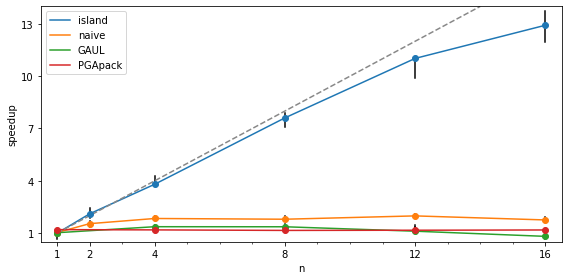

In [18]:
fig, ax = plt.subplots(figsize=(8,4))
df_speedup2 = df_speedup2.replace("gaul", "GAUL")
df_speedup2 = df_speedup2.replace("pga", "PGApack")
legend = ["island", "naive", "GAUL", "PGApack"]
sns.lineplot(ax=ax, x="n", y="wall clock time", hue="mode", hue_order=["island", "naive", "GAUL", "PGApack"], data=df_speedup2,
            err_style="bars", err_kws={"ecolor" : "k", "fmt" : "o"}, estimator=np.median, ci=95)
plt.legend(legend)
plt.plot([1,14],[1, 14], "--", color='#888888')
ax.set(xlabel='n', ylabel='speedup')
# ax.set_title(f"Speedup of baselines with threshold {threshold}")
ax.xaxis.set_major_locator(plt.FixedLocator([1, 2, 4, 8, 12, 16]))
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.FixedLocator([1, 4, 7, 10, 13]))
ax.set_xlim(0.5, 16.5)
ax.set_ylim(0.5, 14)
fig.savefig(f"speedup_all_d1291_{threshold}.pdf", pad_inches=0, bbox_inches="tight")